In [1]:
import spectre
import spectre.IO.H5 as spectre_h5
from spectre.Spectral import Mesh, Basis, Quadrature, logical_coordinates
from spectre.DataStructures import DataVector, Index
from spectre.DataStructures.Tensor import InverseJacobian, Jacobian, Scalar, tnsr
from spectre.NumericalAlgorithms.LinearOperators import power_monitors
from spectre.Domain.Creators import Interval
import spectre.Evolution.DgSubcell as scl
import spectre.IO.H5 as h5
from spectre import Interpolation

from matplotlib import pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib
import matplotlib.animation
import numpy as np

# Set the path to the spectre bin directory. We will use this later for running executables.
from pathlib import Path;
spectre_bin_path = str(Path(spectre.__file__).parent.parent.parent)

# Set up the path to the notebook. We assume input files are next to the notebook.
import os
notebook_path = os.getcwd()

# Overview and goals
The primary goal is to solve a system of PDEs to a given accuracy. This means that both *too much* accuracy and *not enough* accuracy are
bad. For time-dependent PDEs, like the Einstein equations, where we need more or less resolution to achieve the accuracy changes. This means
we must adapt the mesh dynamically: adaptive mesh refinement (AMR). Interestingly, AMR often is used to reduce computational cost, not to
increase resolution.

## Domain decomposition
We decompose the computational domain into a set of non-overlapping Elements.  In each Element the solution is represented at a set of grid
points called the collocation points.  For a DG method we approximate the solution of the system as
$$
u(\xi,t)\approx\sum_{i=0}^{N}u_i(t)\ell_i(\xi)=\sum_{i=0}^{N}c_i(t)P_i(\xi)
$$
where 
- $\ell_i(\xi)$ are Lagrange interpolating polynomials on the interval $\xi \in [-1, 1]$,
- $u_i(t)$ the time-dependent pointwise value ofthe solution at the collocation points (nodal coefficients or values),
- $P_i(\xi)$ the Legendre polynomials,
- and $c_i$ the spectral or modal coefficients.

Using multiple Elements provides a natural way to parallelize the problem, and for complicated geometries such as those used
in compact binary simulations, it is necessary to use multiple Elements to cover the computational domain.

In order to achieve a given accuracy, we can adjust the resolution of a DG method in one of two ways.  The first is to change the number of
collocation points in an Element. This is known a p-refinement as we are changing the order of our polynomial representation of the solution.

Let's show the location of the collocation points as we increase $N \in [2, 12]$:


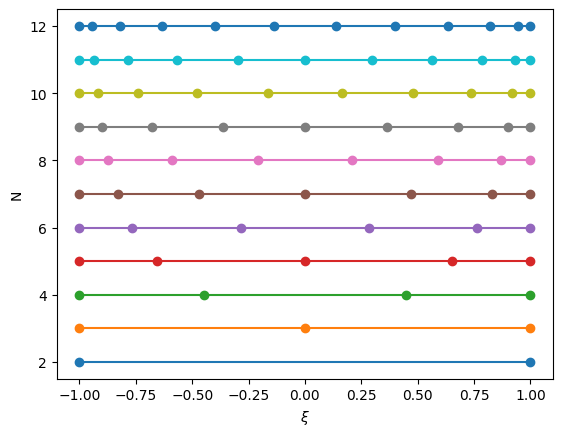

In [4]:
for i in range(2, 13):
    dg_mesh = Mesh[1](i, Basis.Legendre, Quadrature.GaussLobatto)
    dg_logical_coords = logical_coordinates(dg_mesh)
    plt.plot(dg_logical_coords.get(0), np.full((dg_mesh.extents(0)), i), marker='o', linestyle='-')

plt.ylabel("N")
plt.xlabel(r"$\xi$")
plt.show()

Notice that the collocation points are not evenly distributed but clustered towards the endpoints of the Element.  The location of the collocation points is determined by the basis function (in this case Legendre polynomials) and the quadrature (in this case Gauss-Lobatto, which places collocation points on the boundary of the Element).  An alternative basis for DG is Chebyshev polynomials, and an alternative quadrature is Gauss which does not place collocation points on the boundary of the Element.

The second way to adjust the resolution is to change the number of Elements that are used to cover the computational domain. This is known as h-refinement as we are changing the size of the individual Elements with respect to the spatial scale of the problem.  We use a block-based h-refinement scheme where we decompose the computational domain into a set of non-overlapping Blocks.  Each Block is the coarsest Element in a refinement hierarchy.  In each dimension we define a refinement level by the number of times the Block has been split.

Let's show the distribution of Elements as we increase the refinement level $L$:

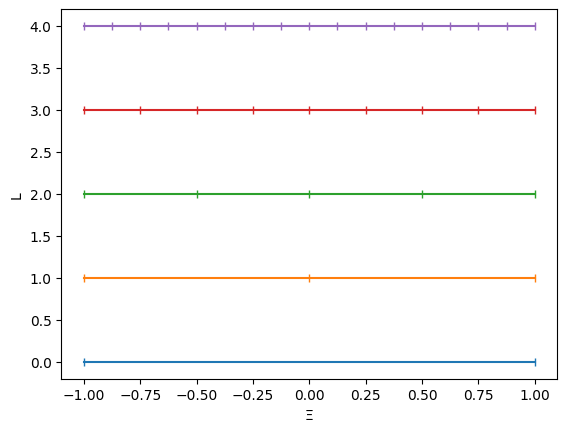

In [5]:
for l in range(0, 5):
    num_pts = 2**l + 1
    block_logical_coords = np.linspace(-1, 1, num = num_pts)
    plt.plot(block_logical_coords, np.full((num_pts), l), marker='|', linestyle='-')

plt.ylabel("L")
plt.xlabel(r"$\Xi$")
plt.show()

### Multiple dimensions

In multiple dimensions, we represent our DG solution as tensor products of polynomials:
$$
u(\vec{\xi},t) \approx\sum_{i=0}^{N_{\xi}}\sum_{j=0}^{N_{\eta}}\sum_{k=0}^{N_{\zeta}}u_{ijk}(t)\ell_i(\xi)\ell_j(\eta)\ell_k(\zeta)
= \sum_{i=0}^{N_{\xi}}\sum_{j=0}^{N_{\eta}}\sum_{k=0}^{N_{\zeta}}c_{ijk}(t)P_i(\xi)P_j(\eta)P_k(\zeta)
$$
where $\vec{\xi} = (\xi,\eta,\zeta)$ are the element logical coordinates that cover the Element in $\xi^i \in [-1, 1]$.

For complicated geometries of the computational domain it is necessary to use multiple distorted Blocks that are then subdivided into Elements.  Each Block is a d-dimensional hypercube with block logical coordinates $\vec{\Xi}$ that cover the block in $\Xi^i \in [-1, 1]$. 
We can uniquely identify each Element by specifying $\{B, \vec{L}, \vec{I}\}$ where $B$ is label of the $B$-th Block, $\vec{L}$ is the refinement level of the Element in each dimension, and $\vec{I}$ is the index $I^i \in [0, 2^{L^i} -1]$ labeling the segment of the refinement level covered by the Element in each dimension (with $I^i = 0$ at the lower end of the Block).  

This then defines a simple linear mapping from the element logical coordinates $\vec{\xi}_K$ of the $K$-th Element to the block logical coordinates $\vec{\Xi}$ of its parent Block:
$$
\Xi^i = h^i_K \xi^i_K + b^i_K - 1
$$
where $h^i_K = 2^{-L^i_K}$, and $b^i_K = h^i_K*(2*I^i_K + 1)$.

Then in order to cover the computational domain, we can define a mapping from the block logical cooordinates of each Block to the coordinates $\vec{x}$ with which we define the computational domain:
$$
\vec{x} = \mathcal{M}_B(\vec{\Xi}_B)
$$
which deforms the hypercube of the Block into a distorted shape

![Binary domain](../01_Monday/images/domain.png "Binary domain")

In multiple dimensions we can adjust the number of collocation points and refinement level in each dimension independently; this is known as anisotropic refinement.  If we demand that each dimension has the same number of collocation points or refinement level, this is known as isotropic refinement.  

For the remainder of this tutorial, we will stick to one spatial dimension.

Let's look at the spectral coefficients for $u = e^{-\xi}$


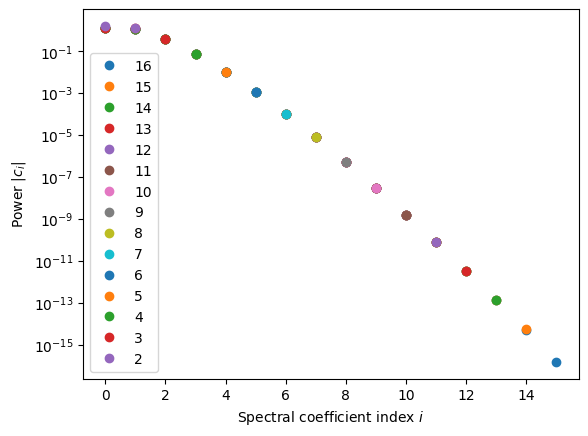

In [6]:
for i in range(16, 1, -1):
    dg_mesh = Mesh[1](i, Basis.Legendre, Quadrature.GaussLobatto)
    dg_logical_coords = logical_coordinates(dg_mesh)
    soln = DataVector(np.exp(-1.0*(dg_logical_coords.get(0))))
    plt.semilogy(np.arange(0, dg_mesh.extents(0)),
                 power_monitors(soln, dg_mesh)[0], marker='o', linestyle='',
                 label=str(i))
    
plt.ylabel("Power $|c_i|$")
plt.xlabel("Spectral coefficient index $i$")
plt.legend()
plt.show()


We see that the coefficients exponentially decay with increasing resolution.

Now let's look at how the error in interpolating $e^{-\xi}$ to an arbitrary point decays with increasing resolution:

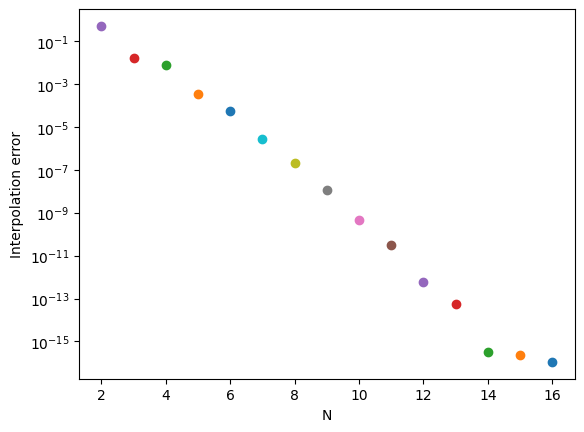

In [7]:
target_logical_coords = [DataVector(1, 0.1)]
exact = DataVector(1, np.exp(-0.1))
for i in range(16, 1, -1):
    dg_mesh = Mesh[1](i, Basis.Legendre, Quadrature.GaussLobatto)
    dg_logical_coords = logical_coordinates(dg_mesh)
    soln = DataVector(np.exp(-1.0*(dg_logical_coords.get(0))))
    interpolator = Interpolation.Irregular1D(dg_mesh, target_logical_coords=[DataVector(1, 0.1)])
    interpolated = interpolator.interpolate(soln)
    error = np.abs(interpolated - exact)
    plt.plot(i, error, marker='o')

plt.ylabel("Interpolation error")
plt.xlabel("N")
plt.yscale('log')
plt.show()

We see the interpolation error also falls off exponentially.

Now let us examine how the interpolation falls off for fixed polynomial order, but we increase the refinement level.

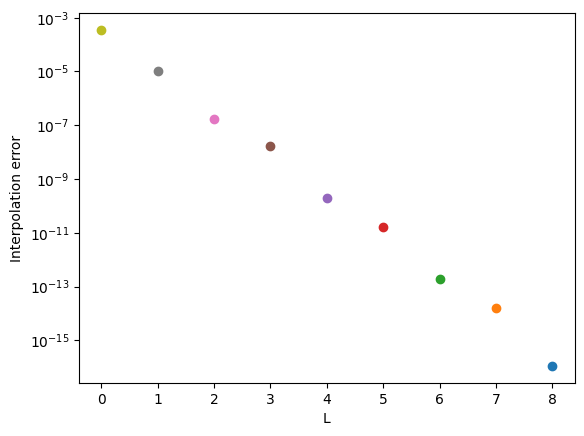

In [8]:
target_block_logical_coords = [DataVector(1, 0.1)]
exact = DataVector(1, np.exp(-0.1))
for i in range(8, -1, -1):
    dg_mesh = Mesh[1](5, Basis.Legendre, Quadrature.GaussLobatto)
    m = 2**(-i)
    element_index = 0
    target_el_coord = 1.1/m - 2*element_index - 1
    while target_el_coord > 1 and element_index < 2**i:
        element_index += 1
        target_el_coord -= 2

    dg_element_logical_coords = logical_coordinates(dg_mesh)
    dg_block_logical_coords = m*(dg_element_logical_coords.get(0) + 2*element_index + 1) - 1
    soln = DataVector(np.exp(-1.0*(dg_block_logical_coords)))
    interpolator = Interpolation.Irregular1D(dg_mesh, target_logical_coords=[DataVector(1, target_el_coord)])
    interpolated = interpolator.interpolate(soln)
    error = np.abs(interpolated - exact)
    plt.plot(i, error, marker='o')

plt.ylabel("Interpolation error")
plt.xlabel("L")
plt.yscale('log')
plt.show()


## The solution and what accuracy means
Since we wish to achieve a given level of accuracy, we must define what we actually mean by that. Again, for a DG method we approximate the solution of the system as
$$
u(\xi,t)\approx\sum_{i=0}^{N}u_i(t)\ell_i(\xi)=\sum_{i=0}^{N}c_i(t)P_i(\xi)
$$
where $\ell_i(\xi)$ are Lagrange interpolating polynomials, $u_i(t)$ the time-dependent pointwise value of the solution at the grid points (nodal coefficients or values), $P_i(\xi)$ the Legendre polynomials, and $c_i$ the spectral or modal coefficients.

Since we can either change the number of modes (p-refinement) or split/join the element(s) (h-refinement), we need a way of deciding which to do. We can divide this into two tasks (1) decide whether we are accurate enough or not (2) decide if we need to change the mesh based on that decision.

In order to decide whether or not we are accurate enough, we need to estimate the error in our solution. Let's define the solution $\hat{u}(\xi,t)$ as
$$
\hat{u}(\xi,t)\approx\sum_{i=0}^{N-1}u_i(t)\ell_i(\xi).
$$
That is, it is our solution but with one fewer grid points inside the element. We can then compute $\mathcal{E}_N\approx|u(\xi,t)-\hat{u}(\xi,t)|$ in the element to estimate the truncation error. If we look at the modal expansion we see that this is actually just $|c_NP_N(\xi)|$. This means we can use the amount of power in the highest (or several highest) modes to estimate the truncation error of the solution. In SpECTRE this is called the `TruncationError` [AMR criterion](https://spectre-code.org/classamr_1_1Criteria_1_1TruncationError.html). By comparing the truncation error estimate to our target truncation error ("target accurracy") we can decide whether or not the solution is accurate enough or too accurate. In the case that the solution is not accurate enough, we must add a grid point to the element to reduce the truncation error.

If the solution is too accurate, whether or not to coarsen/remove a grid point is more difficult. This is because if we remove a grid point, our solution may then no longer be accurate enough. The next time AMR runs it would then decide to add a grid point, which would then make the solution too accurate, and so it would remove the grid point again later, etc. This sort of "flip-flopping" back and forth between resolutions is bad since it creates a lot of noise and also means that sometimes we would be below our target truncation error. Instead, we define another solution $\bar{u}(\xi,t)$ as
$$
\bar{u}(\xi,t)\approx\sum_{i=0}^{N-2}u_i(t)\ell_i(\xi).
$$
Using the same procedure as before, we can estimate the truncation error of this solution by computing $\mathcal{E}_{N-1}\approx|\hat{u}(\xi,t)-\bar{u}(\xi,t)|$. If $\mathcal{E}_{N-1}$ is greater than our target truncation error then we stay at the current resolution. If it is below the target truncation error, then we can safely use one fewer grid points. Of course, this is only one possible approach. Another simpler approach would be to only coarsen if $\mathcal{E}_N$ is $K$ times smaller than the target truncation error.

### Example: p-refinement

To get some intuition, let's look at an example. We will start by creating 3 meshes with 8, 9, and 10 grid points and then evaluating the function $\sin(2 \xi+1.83) + \xi$ on the corresponding grid.

In [9]:
dg_mesh_10 = Mesh[1](10, Basis.Legendre, Quadrature.GaussLobatto)
dg_mesh_9 = Mesh[1](9, Basis.Legendre, Quadrature.GaussLobatto)
dg_mesh_8 = Mesh[1](8, Basis.Legendre, Quadrature.GaussLobatto)

dg_logical_coords_10 = logical_coordinates(dg_mesh_10)
dg_logical_coords_9 = logical_coordinates(dg_mesh_9)
dg_logical_coords_8 = logical_coordinates(dg_mesh_8)
soln_a10 = DataVector(np.sin(2.0 * dg_logical_coords_10.get(0) + 1.83) + dg_logical_coords_10.get(0))
soln_a9 = DataVector(np.sin(2.0 * dg_logical_coords_9.get(0) + 1.83) + dg_logical_coords_9.get(0))
soln_a8 = DataVector(np.sin(2.0 * dg_logical_coords_8.get(0) + 1.83) + dg_logical_coords_8.get(0))

Now let's plot the solutions to see if we can visually see a difference.

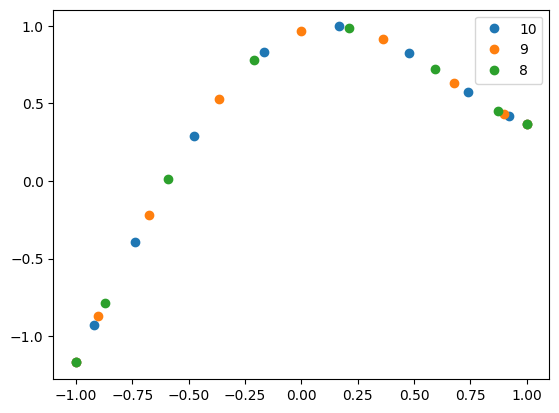

In [10]:
plt.plot(dg_logical_coords_10.get(0), soln_a10, marker='o', linestyle='', label="10")
plt.plot(dg_logical_coords_9.get(0), soln_a9, marker='o', linestyle='', label="9")
plt.plot(dg_logical_coords_8.get(0), soln_a8, marker='o', linestyle='', label="8")
plt.legend()
plt.show()

The solutions are clearly very similar and we can't visually tell the difference. Now let's plot the absolute value of the spectral coefficients to see how rapidly they decay and to get some estimate of what the solution error actually is.

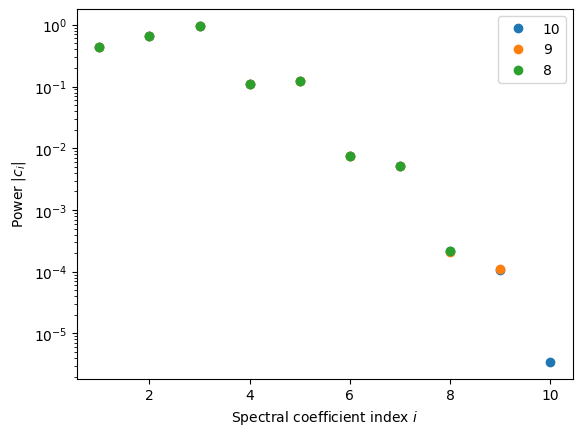

In [11]:
plt.semilogy(np.arange(1, dg_mesh_10.extents(0)+1),
             power_monitors(soln_a10, dg_mesh_10)[0], marker='o', linestyle='',
            label="10")
plt.semilogy(np.arange(1, dg_mesh_9.extents(0)+1),
             power_monitors(soln_a9, dg_mesh_9)[0], marker='o', linestyle='',
            label="9")
plt.semilogy(np.arange(1, dg_mesh_8.extents(0)+1),
             power_monitors(soln_a8, dg_mesh_8)[0], marker='o', linestyle='',
            label="8")
plt.ylabel("Power $|c_i|$")
plt.xlabel("Spectral coefficient index $i$")
plt.legend()
plt.show()

From this we see that the solution error is $\mathcal{E}_N\approx10^{-6}$ and $\mathcal{E}_{N-1}\approx10^{-4}$. Let's interpolate the solutions on the 8 and 9 point grids to the 10 point grid so that we can compute the differences. We can use SpECTRE's interpolation code to interpolate the solution.

In [12]:
interpolator8_to_10 = Interpolation.RegularGrid1D(dg_mesh_8, dg_mesh_10)
interpolator9_to_10 = Interpolation.RegularGrid1D(dg_mesh_9, dg_mesh_10)

soln_a8_10 = interpolator8_to_10.interpolate(soln_a8)
soln_a9_10 = interpolator9_to_10.interpolate(soln_a9)

As a sanity check, let's plot all 3 solutions.

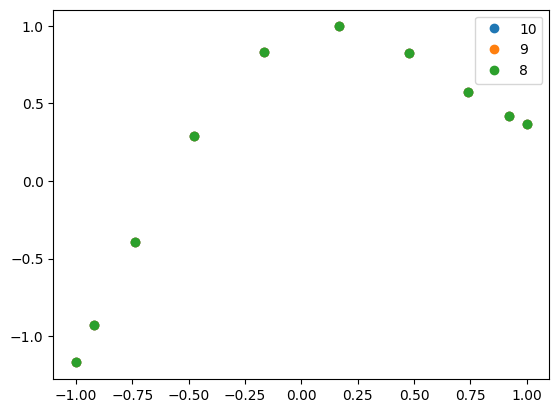

In [13]:
plt.plot(dg_logical_coords_10.get(0), soln_a10, marker='o', linestyle='', label="10")
plt.plot(dg_logical_coords_10.get(0), soln_a9_10, marker='o', linestyle='', label="9")
plt.plot(dg_logical_coords_10.get(0), soln_a8_10, marker='o', linestyle='', label="8")
plt.legend()
plt.show()

All 3 solutions are visually indistinguishable, as we would expect from our error estimates above. Now let's plot $|u-\hat{u}|$ and $|\hat{u}-\bar{u}|$ on a semi-log plot.

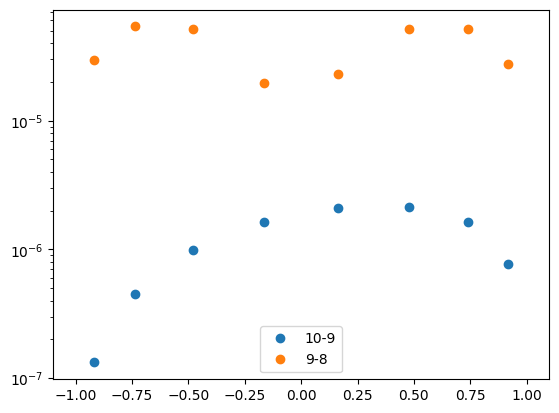

In [14]:
plt.plot(dg_logical_coords_10.get(0), np.abs(soln_a10 - soln_a9_10), marker='o', linestyle='', label="10-9")
plt.plot(dg_logical_coords_10.get(0), np.abs(soln_a9_10 - soln_a8_10), marker='o', linestyle='', label="9-8")
plt.yscale('log')
plt.legend()
plt.show()

We see that our estimate of $\mathcal{E}_N\approx10^{-6}$ and $\mathcal{E}_{N-1}\approx10^{-4}$ are both quite good. This gives us some confidence in our truncation error estimation approach.

### Example: h-refinement
Now we turn to the more challenging task of deciding when to h-refine instead of p-refine. 

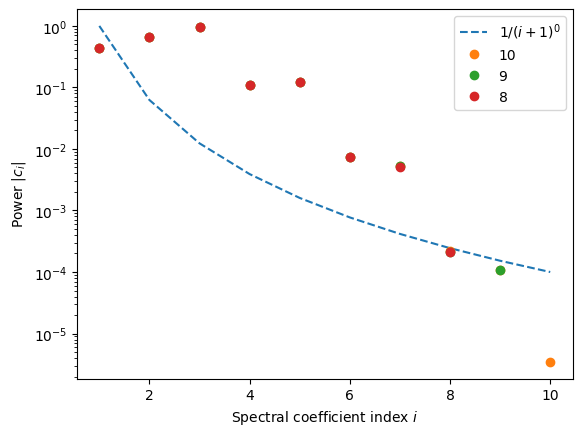

In [15]:
n = np.arange(1, dg_mesh_10.extents(0)+1)
plt.semilogy(n, 1/n**4, '--', label=f"$1 / (i+1)^{i}$")

plt.semilogy(np.arange(1, dg_mesh_10.extents(0)+1),
             power_monitors(soln_a10, dg_mesh_10)[0], marker='o', linestyle='',
            label="10")
plt.semilogy(np.arange(1, dg_mesh_9.extents(0)+1),
             power_monitors(soln_a9, dg_mesh_9)[0], marker='o', linestyle='',
            label="9")
plt.semilogy(np.arange(1, dg_mesh_8.extents(0)+1),
             power_monitors(soln_a8, dg_mesh_8)[0], marker='o', linestyle='',
            label="8")
plt.ylabel("Power $|c_i|$")
plt.xlabel("Spectral coefficient index $i$")
plt.legend()
plt.show()

In [16]:
dg_mesh_7 = Mesh[1](7, Basis.Legendre, Quadrature.GaussLobatto)
dg_logical_coords_7 = logical_coordinates(dg_mesh_7)
soln_a7 = DataVector(np.sin(2.0 * dg_logical_coords_7.get(0) + 1.83) + dg_logical_coords_7.get(0))

print("Resolution 8 series converges: ", not scl.persson_tci(Scalar[DataVector](soln_a8), dg_mesh_8, 4.0, 1))
print("Resolution 7 series converges: ", not scl.persson_tci(Scalar[DataVector](soln_a7), dg_mesh_7, 4.0, 1))

Resolution 8 series converges:  True
Resolution 7 series converges:  False


**Note**: Lesson here is that if you start at low resolution, you will over h-refine, then p-refine, and the possible h-coarsen and then more p-refine.

## Simulation example: Scalar Waves in 1D
Let's see things in action.  We will evolve a scalar wave in 1D, allowing the grid to p-refine based on the TruncationError AMR criterion.
The scalar wave system is the solution to:
$$
\frac{\partial^2 \Psi}{\partial t^2} = \nabla^2 \Psi
$$
It is straightforward to show that a plane wave is a solution to the wave equation, given by
$$
\Psi(\vec{x},t) = F(u(\vec{x},t))
$$
where the profile $F$ of the plane wave is an arbitrary one-dimensional function of 
$$
u = \vec{k} \cdot (\vec{x} - \vec{x_c}) - \omega t
$$
with the wave vector $\vec{k}$, the frequency $\omega = ||\vec{k}||$ and initial center of the profile $\vec{x_c}$.

In order to solve the system in first-order form, we introduce the auxiliary variables $\Pi = -\partial_t \Psi$ and $\Phi_i = \partial_i \Psi$ in order to get the first-order system:
$$
\begin{align}
\partial_t \Psi &= - \Pi \\
\partial_t \Pi &=  -\partial^i \Phi_i \\
\partial_t \Phi_i &= -\partial_i \Pi
\end{align}
$$

We solve this system on the interval $x \in [1, 3]$ imposing analytic boundary conditions for a plane wave with a wave vector $k = 1$, centered at $x_c = 0$, and with a Gaussian profile
$$
F(u) = A \exp\left(-\frac{(u-c)^2}{w^2}\right)
$$
with amplitude $A = 1$, center $c = -6$ and width $w = 1$.

Initially (at $t=0$), the scalar field will be effectively zero on the interval, but as the system is evolved, a Gaussian pulse will enter the domain from the left and propagate at the speed of light to the right. 

The interval is split into four elements, each with an initial resolution of 4 grid points.  

We will now evolve the system from $t = 0$ until $t = 15$ with a time-step of $\Delta t = 0.001$ allowing the mesh to be refined every $\Delta t_{AMR} = 0.05$ with a target truncation error of $\mathcal{E}_N = 10^{-6}$.

In [19]:
! EvolveScalarWave1D --input-file=./Sw1D.yaml

Charm++> Running on MPI version: 3.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in SMP mode: 1 processes, 1 worker threads (PEs) + 1 comm threads per process, 1 PEs total
Charm++> The comm. thread both sends and receives messages
Converse/Charm++ Commit ID: v7.0.0-3-g65f828701
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (2 sockets x 1 cores x 1 PUs = 2-way SMP)
Charm++> cpu topology info is gathered in 0.001 seconds.

Executing 'EvolveScalarWave1D' using 1 processors.
Launch command line: EvolveScalarWave1D --input-file=./Sw1D.yaml
Charm++ startup time in seconds: 0.110173
Date and time at startup: Tue Aug  6 11:52:11 2024

SpECTRE Build Information:
Version:                      2024.08.03
Compiled on host:             node1828.oscar.ccv.brown.edu
Compiled in directory:        /users/ccvws98/spectre/build
Source directory is:          /users/ccvws98/spectre
Compiled on git branch:       develop
Compiled on git revision:   

In [20]:
volume_file = h5.H5File("Volume0.h5")
volume_data = volume_file.get_vol("Fields.vol")
obs_ids = volume_data.list_observation_ids()
coords = [np.asarray(volume_data.get_tensor_component(obs_ids[obs_int], "InertialCoordinates_x").data).copy()
                  for obs_int in range(len(obs_ids))]
psi = [np.asarray(volume_data.get_tensor_component(obs_ids[obs_int], "Psi").data).copy()
                  for obs_int in range(len(obs_ids))]
times = [volume_data.get_observation_value(obs_ids[obs_int])
              for obs_int in range(len(obs_ids))]
def plot_step_at(obs_int):
    plt.cla()
    plt.plot(coords[obs_int], psi[obs_int], marker='o', linestyle='')
    plt.title(f"Time {times[obs_int]:1.2f}")

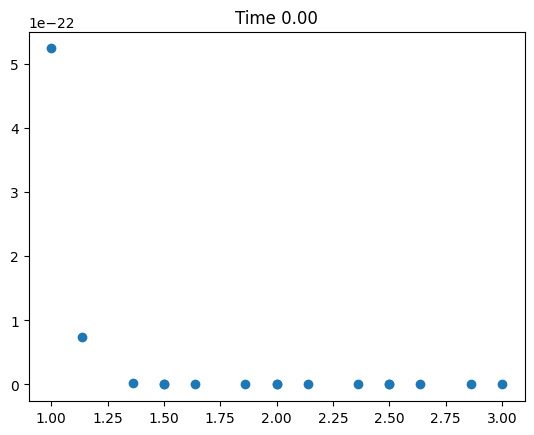

In [21]:
fig, ax = plt.subplots()
matplotlib.animation.FuncAnimation(fig, plot_step_at, frames=len(psi))

Note that at the beginning the grid becomes coarser so that each element has only two grid points which is the minimum allowed resolution for our choice of basis function (Legendre polynomials) and quadrature (Gauss-Lobatto).  As the Gaussian pulse enters the grid, the resolution increases, and after the pulse leaves the grid, the resolution again coarsens.


Now let us plot the power monitors (the absolute values of the spectral coefficients $c_i$) for each element on a semi-log scale (shown on the left) overlayed on the evolved scalar field.

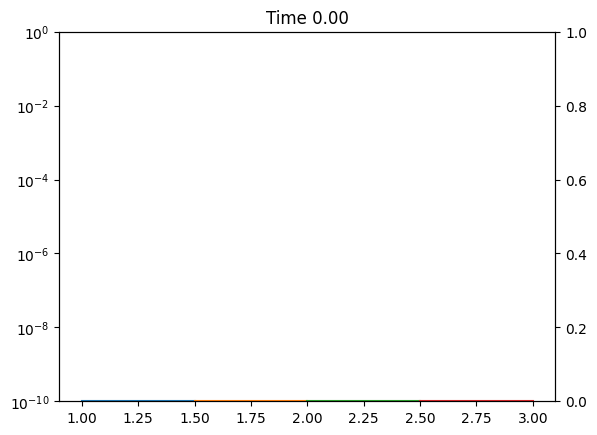

In [22]:
sw_data_by_element = volume_data.get_data_by_element(None, None, ["Psi", "InertialCoordinates_x"])

fig, ax = plt.subplots()
ax2 = ax.twinx() 
def plot_sw_power_monitors(obs_int):
    ax.cla()
    ax2.cla()
    data_at_this_time = sw_data_by_element[obs_int][2]
    for element_data in data_at_this_time:
        coords = None
        psi = None
        for tensor_component in element_data.tensor_components:
            if tensor_component.name == "Psi":
                psi = DataVector(tensor_component.data)
            elif tensor_component.name == "InertialCoordinates_x":
                coords = DataVector(tensor_component.data)
        element_mesh = Mesh[1](element_data.extents[0], element_data.basis[0], element_data.quadrature[0])
        psi_power_monitor = power_monitors(psi, element_mesh)[0]
        ax.semilogy(coords, psi_power_monitor, marker='o', linestyle='')
        ax2.plot(coords, psi)
    ax.set_ylim(1e-10, 1)
    ax2.set_ylim(0, 1.0)
    
    plt.title(f"Time {sw_data_by_element[obs_int][1]:1.2f}")
matplotlib.animation.FuncAnimation(fig, plot_sw_power_monitors, frames=len(sw_data_by_element))